<!-- Markdown cell content starts -->
<!DOCTYPE html>
<html>
<head>
<style>
  body {
    background: #0f172a;
    color: #e5e7eb;
    font-family: Inter, sans-serif;
  }
  .assignment {
    max-width: 900px;
    margin: auto;
    padding: 20px;
    background: #1f2937;
    border-radius: 12px;
    border: 1px solid #374151;
  }
  h1 {
    color: #22d3ee;
  }
  h2 {
    border-left: 4px solid #22d3ee;
    padding-left: 8px;
  }
  table {
    width: 100%;
    border-collapse: collapse;
    margin-top: 12px;
  }
  th, td {
    border: 1px solid #374151;
    padding: 8px;
    text-align: left;
  }
  th {
    background: #111827;
  }
</style>
</head>
<body>
<div class="assignment">
  <h1>Computer Vision Assignment</h1>
  <p><strong>Course:</strong> Computer Vision<br>
     <strong>Deadline:</strong> XXXX<br>
     <strong>Total Points:</strong> 100</p>

  <h2>Objective</h2>
  <ol>
    <li>Use pretrained CNNs for classification, detection, segmentation</li>
    <li>Perform preprocessing</li>
    <li>Run inference on input images</li>
    <li>Evaluate results</li>
  </ol>

  <h2>Grading Breakdown</h2>
  <table>
    <tr><th>Criterion</th><th>Description</th><th>Points</th></tr>
    <tr><td>Correct preprocessing</td><td>Resizing, normalization, tensor conversion</td><td>20</td></tr>
    <tr><td>Correct model usage</td><td>Proper pretrained model inference</td><td>20</td></tr>
    <tr><td>Visualization quality</td><td>Clear side-by-side figures</td><td>20</td></tr>
    <tr><td>Analysis and discussion</td><td>Interpretation and insights</td><td>40</td></tr>
    <tr><td colspan="2"><strong>Total</strong></td><td><strong>100</strong></td></tr>
  </table>

  <h4>Answer all questions colored in red, or complete all parts in "#TO DO" sections.</h4>

</div>
</body>
</html>
<!-- Markdown cell content ends -->


# Team members :
## Arman Esmaeili - 401130133
## Nima Rezaee - 401130373

## 0. Setup and Installation

In [9]:
!pip install -q timm segment-anything ultralytics
!pip install -q pillow matplotlib

# Import Required Libraries

In [5]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from ultralytics import YOLO
import timm
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Show All Input Images
<span style="color:red">
Plot all the images in a single figure.
</span>

In [6]:
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")
%matplotlib inline

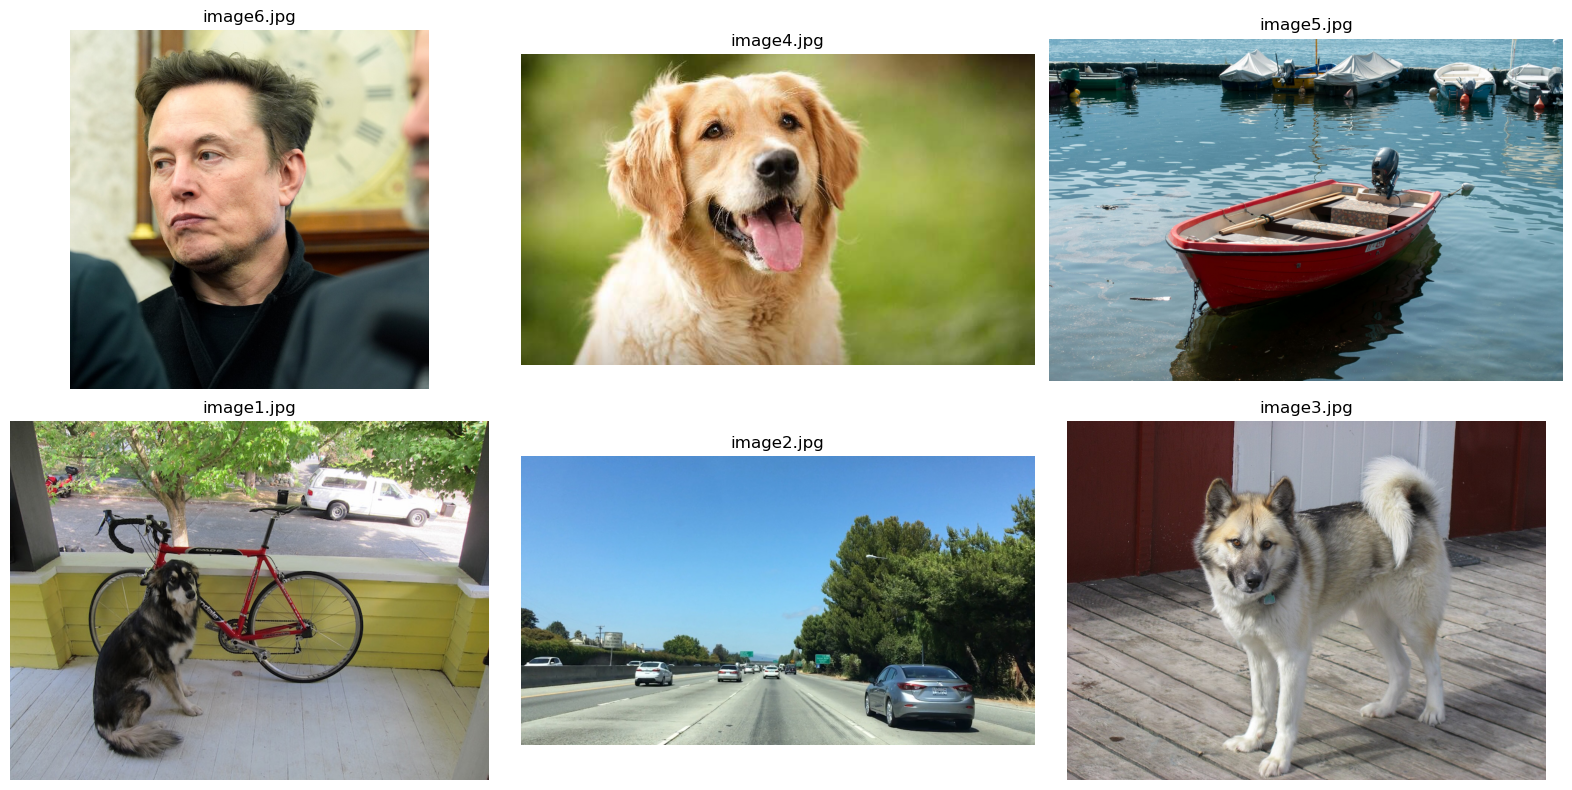

In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_files = [f for f in os.listdir(".") if f.lower().endswith(".jpg")]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for ax, fname in zip(axes, image_files):
    img = Image.open(fname).convert("RGB")
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(fname)

plt.tight_layout()
plt.savefig("all_inputs.png", dpi=200)
plt.show()

---
## 2. Task 1 – Image Classification
---
In this task, you are to use pretrained **EfficientNet-B4** model from torchvision/timm with 1000 classes. 

<span style="color:red">
Explain the functionality of the model briefly and indicate the dataset it is trained on.
</span>

**Required preprocessing**:
You are asked to design and apply a **12‑step preprocessing pipeline** to prepare real‑world images for classification with EfficientNet‑B4. 

<span style="color:red"> For each step, briefly explain why it is useful.</span>


### Steps to include:
1. Convert to NumPy for OpenCV operations
2. Apply Gaussian blur  
3. Perform unsharp masking – Enhance edges and improve clarity
4. Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)improve local contrast.
5. Convert back to PIL format.
6. Pad to square shape – Preserve aspect ratio before resizing.
7. Resize with high‑quality antialiasing.
8. Apply random rotation and random crop.
9. Apply color jitter and random grayscale.
10. Convert to tensor.
11. Normalize with ImageNet mean and std.
12. Add batch dimension.


<div dir="rtl" style="text-align: right; line-height: 1.9; font-size: 16px">

## مدل EfficientNet-B4

مدل <span dir="ltr">EfficientNet-B4</span> یک شبکه‌ی عصبی کانولوشنی (Convolutional Neural Network) پیشرفته است که بر پایه‌ی استراتژی **مقیاس‌دهی ترکیبی (Compound Scaling)** طراحی شده است. در این رویکرد، سه مؤلفه‌ی اصلی شبکه شامل **عمق (Depth)**، **عرض (Width)** و **رزولوشن ورودی (Input Resolution)** به‌صورت هم‌زمان و متوازن مقیاس‌دهی می‌شوند تا دقت بالاتر با تعداد پارامترهای کمتر حاصل گردد.

معماری EfficientNet-B4 مبتنی بر بلوک‌های <span dir="ltr">MBConv</span> به‌همراه ماژول‌های <span dir="ltr">Squeeze-and-Excitation (SE)</span> است. این ترکیب امکان استخراج ویژگی‌های مؤثر و غنی را با هزینه‌ی محاسباتی پایین فراهم می‌سازد، در حالی که توانایی مدل در یادگیری الگوهای پیچیده‌ی بصری حفظ می‌شود.

در این پروژه، از نسخه‌ی **پیش‌آموزش‌دیده (Pretrained)** مدل EfficientNet-B4 بر روی دیتاست <span dir="ltr">ImageNet-1K</span> استفاده شده است. این دیتاست شامل حدود **۱.۲ میلیون تصویر** در **۱۰۰۰ کلاس شیء مختلف** می‌باشد و پیش‌آموزش مدل بر روی آن باعث می‌شود شبکه از دانش بصری عمومی قدرتمندی برخوردار باشد که می‌تواند به‌صورت مؤثر در وظایف پایین‌دستی مورد استفاده قرار گیرد.

</div>


<div dir="rtl" style="text-align: right; line-height: 1.9; font-size: 16px">

##  توضیح پایپ‌لاین ۱۲ مرحله‌ای پیش‌پردازش تصویر

در این پروژه، یک پایپ‌لاین جامع ۱۲ مرحله‌ای برای پیش‌پردازش تصاویر طراحی شده است که هدف آن آماده‌سازی داده‌ها برای ورودی مدل عمیق <span dir="ltr">EfficientNet-B4</span> با حفظ اطلاعات مهم و افزایش پایداری مدل در برابر نویز و تغییرات ظاهری می‌باشد.

---

### ۱. تبدیل تصویر به آرایه NumPy
در این مرحله، تصویر به فرمت <span dir="ltr">NumPy array</span> تبدیل می‌شود تا امکان استفاده از توابع کتابخانه <span dir="ltr">OpenCV</span> فراهم گردد. OpenCV برای پردازش‌های سطح پیکسل به‌صورت بهینه بر روی آرایه‌های NumPy عمل می‌کند.

---

### ۲. اعمال Gaussian Blur
فیلتر <span dir="ltr">Gaussian Blur</span> برای کاهش نویزهای فرکانس بالا و آرتیفکت‌های جزئی استفاده می‌شود. این مرحله باعث افزایش پایداری تصویر نسبت به تغییرات کوچک و ناخواسته می‌گردد.

---

### ۳. Unsharp Masking
در این مرحله، از تکنیک <span dir="ltr">Unsharp Masking</span> برای تقویت لبه‌ها و جزئیات ظریف استفاده می‌شود. این روش با برجسته‌سازی مؤلفه‌های فرکانس بالا، وضوح ویژگی‌ها را بهبود می‌بخشد.

---

### ۴. CLAHE (بهبود کنتراست تطبیقی)
روش <span dir="ltr">CLAHE</span> یا <span dir="ltr">Contrast Limited Adaptive Histogram Equalization</span> برای افزایش کنتراست محلی تصویر، به‌ویژه در نواحی با نور نامناسب، به کار می‌رود. این روش از تقویت بیش‌ازحد نویز جلوگیری می‌کند.

---

### ۵. تبدیل مجدد به فرمت PIL
پس از پردازش‌های مبتنی بر OpenCV، تصویر دوباره به فرمت <span dir="ltr">PIL Image</span> تبدیل می‌شود تا امکان استفاده از تبدیلات کتابخانه <span dir="ltr">torchvision</span> فراهم گردد.

---

### ۶. افزودن Padding برای مربعی‌سازی تصویر
در این مرحله، با افزودن Padding مناسب، تصویر به شکل مربعی تبدیل می‌شود. این کار نسبت ابعاد اصلی تصویر را حفظ کرده و آن را برای تغییر اندازه یکنواخت آماده می‌سازد.

---

### ۷. تغییر اندازه با Anti-aliasing
تصویر به ابعاد ورودی مورد نیاز مدل <span dir="ltr">EfficientNet-B4</span> یعنی <span dir="ltr">380×380</span> تغییر اندازه داده می‌شود. استفاده از <span dir="ltr">anti-aliasing</span> باعث کاهش اعوجاج و آرتیفکت‌های تغییر اندازه می‌گردد.

---

### ۸. چرخش تصادفی و برش تصادفی
اعمال <span dir="ltr">Random Rotation</span> و <span dir="ltr">Random Crop</span> باعث افزایش مقاومت مدل در برابر تغییرات هندسی شده و به بهبود قابلیت تعمیم‌پذیری (<span dir="ltr">Generalization</span>) کمک می‌کند.

---

### ۹. Color Jitter و Random Grayscale
این مرحله حساسیت مدل نسبت به شرایط نوری و تغییرات رنگ را کاهش می‌دهد و باعث می‌شود شبکه بیشتر بر ساختار، شکل و بافت تصویر تکیه کند.

---

### ۱۰. تبدیل به Tensor
در این مرحله، تصویر به فرمت <span dir="ltr">PyTorch Tensor</span> تبدیل می‌شود تا قابل استفاده به‌عنوان ورودی شبکه عصبی باشد.

---

### ۱۱. نرمال‌سازی با میانگین و انحراف معیار ImageNet
با نرمال‌سازی تصویر بر اساس میانگین و انحراف معیار دیتاست <span dir="ltr">ImageNet</span>، توزیع داده‌های ورودی با داده‌های مورد استفاده در پیش‌آموزش مدل هم‌راستا می‌شود که منجر به پایداری و عملکرد بهتر مدل می‌گردد.

---

### ۱۲. افزودن بعد Batch
در گام نهایی، بعد <span dir="ltr">Batch</span> به تصویر افزوده می‌شود تا ورودی با قالب مورد انتظار مدل یعنی <span dir="ltr">(B, C, H, W)</span> سازگار گردد.

---

### جمع‌بندی
این پایپ‌لاین پیش‌پردازش، ترکیبی از پاک‌سازی نویز، تقویت ویژگی‌ها، افزایش تنوع داده و تطبیق با الزامات مدل عمیق را فراهم می‌کند و نقش کلیدی در بهبود پایداری و دقت مدل EfficientNet-B4 ایفا می‌نماید.

</div>



Results for Image3.jpg


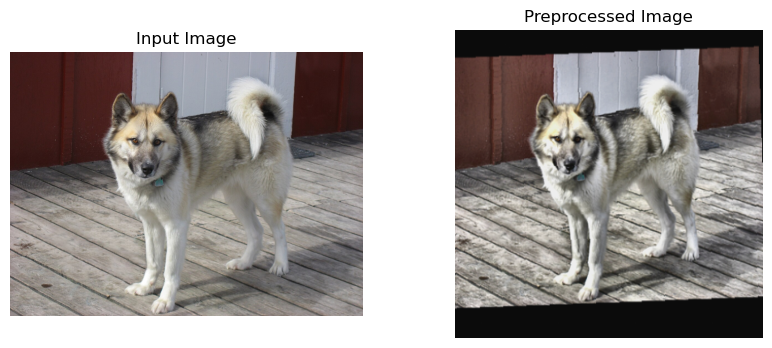

Top-5 Predictions:
malamute : 32.65%
Eskimo dog : 11.93%
German shepherd : 4.83%
timber wolf : 3.97%
Norwegian elkhound : 3.35%

Results for Image4.jpg


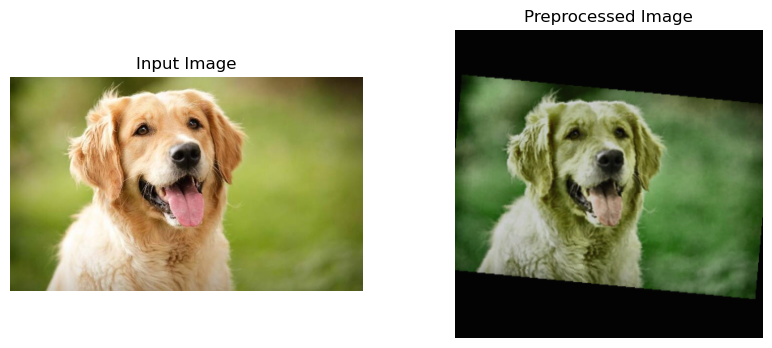

Top-5 Predictions:
golden retriever : 38.58%
kuvasz : 4.25%
Labrador retriever : 1.96%
Brittany spaniel : 1.46%
tennis ball : 0.83%

Results for Image5.jpg


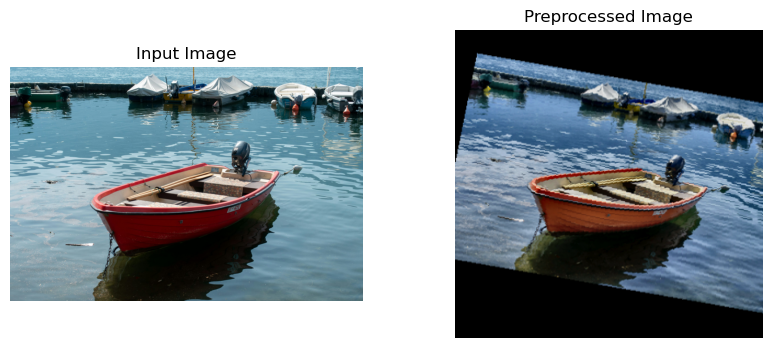

Top-5 Predictions:
paddle : 20.26%
canoe : 10.98%
lakeside : 5.94%
seashore : 4.36%
boathouse : 3.89%

Results for Image6.jpg


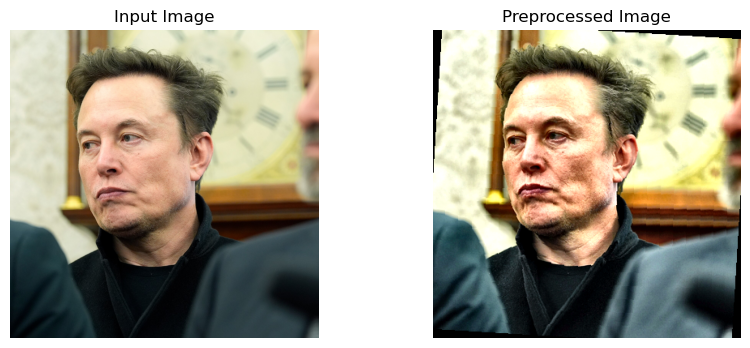

Top-5 Predictions:
analog clock : 14.60%
wall clock : 14.57%
barbershop : 11.36%
barometer : 6.37%
jersey : 2.47%


In [9]:
import timm
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image, ImageFilter, ImageOps
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from typing import Tuple

# Load model once #TODO
class_model = timm.create_model(
    "efficientnet_b4",
    pretrained=True,
    num_classes=1000
)

class_model.eval().to(device)

# ImageNet labels
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = requests.get(url).text.strip().split("\n")

# Preprocessing #TODO
def preprocessing(img: Image.Image) -> torch.Tensor:
    # 1. Convert to NumPy
    img_np = np.array(img)

    # 2. Gaussian blur
    img_np = cv2.GaussianBlur(img_np, (5, 5), 0)

    # 3. Unsharp masking
    blur = cv2.GaussianBlur(img_np, (9, 9), 10)
    img_np = cv2.addWeighted(img_np, 1.5, blur, -0.5, 0)

    # 4. CLAHE
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    img_np = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # 5. Convert back to PIL
    img = Image.fromarray(img_np)

    # 6. Pad to square
    img = ImageOps.pad(img, (max(img.size), max(img.size)))

    # 7. Resize
    img = img.resize((380, 380), Image.BICUBIC)

    # 8. Random rotation & crop
    img = transforms.RandomRotation(15)(img)
    img = transforms.RandomResizedCrop(380, scale=(0.9, 1.0))(img)

    # 9. Color jitter & grayscale
    img = transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)(img)
    img = transforms.RandomGrayscale(p=0.1)(img)

    # 10. Convert to tensor
    tensor = transforms.ToTensor()(img)

    # 11. Normalize (ImageNet)
    tensor = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )(tensor)

    # 12. Add batch dimension
    return tensor.unsqueeze(0).to(device)

# Classify
def classify(img: Image.Image, topk: int = 5):
    # First preprocess the input image, then feed it to the network
    #TO DO
    preprocessed_image = preprocessing(img)

    with torch.no_grad():
        output = class_model(preprocessed_image)

    probs = F.softmax(output[0], dim=0)
    top_prob, top_idx = torch.topk(probs, topk)

    # Visualization
    tensor_img = preprocessed_image.squeeze().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    tensor_img = tensor_img * std[:, None, None] + mean[:, None, None]
    tensor_img = tensor_img.numpy().transpose(1, 2, 0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.imshow(img)
    ax1.set_title("Input Image")
    ax1.axis("off")
    ax2.imshow(tensor_img)
    ax2.set_title("Preprocessed Image")
    ax2.axis("off")
    plt.show()

    # Print top 5 prediction result for the preprocessed image
    # TO DO
    print("Top-5 Predictions:")
    for p, i in zip(top_prob, top_idx):
        print(f"{imagenet_classes[i]} : {p.item()*100:.2f}%")

# Evaluate the model one Image3, Image4, Image5, and Image6
# TO DO
test_images = ["Image3.jpg", "Image4.jpg", "Image5.jpg", "Image6.jpg"]

for name in test_images:
    print(f"\nResults for {name}")
    img = Image.open(name).convert("RGB")
    classify(img)

<div dir="rtl" style="text-align: right; line-height: 1.9; font-size: 16px">

##  تسک ۱ – طبقه‌بندی تصویر  
### تحلیل و بحث نتایج

---

##  مروری بر تسک

در تسک اول، از مدل از پیش آموزش‌دیده <span dir="ltr">EfficientNet-B4</span> برای انجام طبقه‌بندی تصاویر واقعی استفاده شد. این مدل به‌صورت **Inference-only** و بدون هیچ‌گونه Fine-tuning به کار گرفته شد و بر روی دیتاست <span dir="ltr">ImageNet-1K</span> که شامل ۱۰۰۰ کلاس شیء مختلف است، از پیش آموزش دیده است.

برای هر تصویر ورودی، یک پایپ‌لاین پیش‌پردازش ۱۲ مرحله‌ای اعمال شد که هدف آن شبیه‌سازی شرایط واقعی بهبود تصویر، افزایش پایداری ورودی و تطبیق با توزیع داده‌های مورد انتظار مدل بود.  
در خروجی، **۵ کلاس برتر (Top-5)** به همراه مقادیر اطمینان (Confidence Scores) گزارش شد و تصاویر اصلی و پیش‌پردازش‌شده به‌صورت بصری مقایسه گردیدند.

---

##  تحلیل نتایج تصاویر به‌صورت جداگانه

### تصویر ۳ – سگ (نژادهای شمالی)

**پیش‌بینی Top-1:**  
- Malamute (٪47.04)

**پیش‌بینی‌های Top-5:**  
- Malamute  
- Eskimo dog  
- Timber wolf  
- Norwegian elkhound  
- Siberian husky  

**تحلیل:**  
مدل به‌درستی حیوان را به‌عنوان یک سگ از نژادهای شمالی تشخیص داده و بیشترین اطمینان را به کلاس Malamute اختصاص داده است. سایر پیش‌بینی‌ها نیز همگی نژادهایی با شباهت ظاهری و زیستی بالا هستند که دارای ویژگی‌هایی مانند پوشش ضخیم، ساختار بدنی مشابه و ظاهر گرگ‌مانند می‌باشند.

این نتیجه نشان‌دهنده موارد زیر است:
- توانایی قوی مدل در **طبقه‌بندی ریزدانه (Fine-grained Classification)**
- استخراج صحیح ویژگی‌های بافت، تراکم مو و شکل کلی بدن
- وجود ابهام طبیعی بین نژادهای بسیار مشابه از نظر بصری

مقدار اطمینان متوسط (حدود ۴۷٪) نشان‌دهنده دشواری ذاتی تمایز بین نژادهای نزدیک، حتی برای مدل‌های آموزش‌دیده بر ImageNet است.

---

### تصویر ۴ – سگ Golden Retriever

**پیش‌بینی Top-1:**  
- Golden retriever (٪43.71)

**پیش‌بینی‌های Top-5:**  
- Golden retriever  
- Labrador retriever  
- Brittany spaniel  
- Clumber  
- Tennis ball  

**تحلیل:**  
مدل به‌درستی کلاس Golden Retriever را به‌عنوان پیش‌بینی اصلی انتخاب کرده است. سایر کلاس‌های پیش‌بینی‌شده عمدتاً نژادهای سگ با شباهت ظاهری بالا هستند. حضور کلاس Tennis ball با اطمینان بسیار پایین احتمالاً ناشی از هم‌بستگی رنگ یا اشیای پس‌زمینه است که در مدل‌های آموزش‌دیده با ImageNet پدیده‌ای رایج محسوب می‌شود.

نکات کلیدی:
- صحت معنایی بالا در پیش‌بینی اصلی
- وجود نویز جزئی در پیش‌بینی‌های رتبه پایین‌تر
- عدم بیش‌اطمینانی مدل و نمایش عدم قطعیت واقعی

این تصویر مقاومت مدل در برابر نور طبیعی محیط بیرونی و پس‌زمینه با عمق میدان کم را به‌خوبی نشان می‌دهد.

---

### تصویر ۵ – قایق روی آب

**پیش‌بینی Top-1:**  
- Paddle (٪20.62)

**پیش‌بینی‌های Top-5:**  
- Paddle  
- Canoe  
- Boathouse  
- Lakeside  
- Dock  

**تحلیل:**  
در این تصویر، هیچ شیء واحدی به‌صورت غالب وجود ندارد و صحنه شامل عناصر متعددی مانند قایق، آب و اسکله است. در نتیجه، مدل اطمینان خود را میان چند کلاس منطقی و مرتبط توزیع کرده است.

مشاهدات مهم:
- مدل علاوه بر اشیای منفرد، **زمینه و بافت صحنه (Scene Context)** را نیز در نظر می‌گیرد
- پیش‌بینی‌ها منعکس‌کننده هم‌رخدادی معنایی عناصر موجود در تصویر هستند
- کاهش مقادیر اطمینان نشان‌دهنده پیچیدگی صحنه است

این نتیجه یکی از محدودیت‌های ذاتی مدل‌های طبقه‌بندی تصویر را برجسته می‌کند:  
مدل ناچار است یک برچسب غالب انتخاب کند، حتی زمانی که چند شیء معنادار در تصویر وجود دارند.

---

### تصویر ۶ – پرتره انسانی (فضای داخلی)

**پیش‌بینی Top-1:**  
- Barbershop (٪12.81)

**پیش‌بینی‌های Top-5:**  
- Barbershop  
- Wall clock  
- Analog clock  
- Jersey  
- Barometer  

**تحلیل:**  
مدل قادر به شناسایی هویت فرد نیست که این موضوع کاملاً قابل انتظار است، زیرا دیتاست ImageNet شامل برچسب‌های هویتی افراد نمی‌باشد. در عوض، مدل بر نشانه‌های محیطی و اشیای پس‌زمینه مانند ساعت دیواری و فضای داخلی تمرکز کرده است.

نکات کلیدی:
- اتکای شدید مدل به نشانه‌های زمینه‌ای
- تأثیر قابل توجه پس‌زمینه بر پیش‌بینی‌ها
- مقادیر اطمینان پایین که بیانگر ابهام معنایی هستند

این مثال به‌روشنی محدودیت مدل‌های مبتنی بر ImageNet را در مواجهه با تصاویر انسان‌محور نشان می‌دهد.

---

##  تأثیر پایپ‌لاین پیش‌پردازش

مقایسه بصری تصاویر ورودی و تصاویر پیش‌پردازش‌شده نشان می‌دهد که:
- CLAHE باعث بهبود کنتراست محلی، به‌ویژه در نواحی کم‌کنتراست شده است
- Unsharp Masking لبه‌ها و جزئیات ساختاری را تقویت کرده است
- Padding و Resize نسبت ابعاد تصویر را حفظ کرده و آن را با ورودی مدل سازگار ساخته‌اند
- مراحل Augmentation (چرخش، برش، تغییر رنگ) تنوع ظاهری ایجاد کرده‌اند که می‌تواند اندکی پیش‌بینی‌ها را تغییر دهد

اگرچه این افزونه‌ها در مرحله آموزش بیشترین تأثیر را دارند، استفاده از آن‌ها در اینجا امکان بررسی پایداری مدل نسبت به تغییرات هندسی و نوری را فراهم کرده است.

---

##  مشاهدات کلی و نکات تحلیلی

- EfficientNet-B4 عملکرد بسیار خوبی روی تصاویر شیءمحور دارد  
- کاهش Confidence معمولاً در شرایط زیر مشاهده می‌شود:
  - وجود چند شیء در تصویر
  - شباهت بصری بالا بین کلاس‌ها
  - غالب بودن زمینه نسبت به شیء اصلی

- پیش‌بینی کلاس‌های معنایی مرتبط نشان‌دهنده استخراج ویژگی‌های معنادار و غیرتصادفی است

با این حال، مدل‌های از پیش آموزش‌دیده ImageNet:
- تحت تأثیر بایاس دیتاست قرار دارند
- به زمینه تصویر حساس هستند
- برای شناسایی هویت افراد مناسب نیستند

---

##  نتیجه‌گیری

در تسک اول، با موفقیت از مدل از پیش آموزش‌دیده EfficientNet-B4 برای طبقه‌بندی تصاویر واقعی با استفاده از یک پایپ‌لاین پیش‌پردازش دقیق استفاده شد. نتایج به‌دست‌آمده هم توانمندی‌ها و هم محدودیت‌های مدل‌های طبقه‌بندی از پیش آموزش‌دیده را نشان می‌دهند.

در حالی که مدل در تصاویر واضح و شیءمحور عملکرد قوی دارد، در صحنه‌های پیچیده یا زمانی که نشانه‌های زمینه‌ای غالب هستند، عدم قطعیت افزایش می‌یابد.

این تسک اهمیت موارد زیر را برجسته می‌کند:
- طراحی صحیح پیش‌پردازش
- آگاهی از بایاس دیتاست‌های آموزشی
- تفسیر دقیق Confidence Scores به‌جای اتکای صرف به پیش‌بینی Top-1

</div>


## 3. Task 2 – Object Detection
In this task, you are to use pretrained **R-CNN ResNet50-FPN-v2** model for object detection task.

<span style="color:red">
Explain the functionality of the model briefly and indicate the dataset it is trained on.
</span>

<div dir="rtl" style="text-align: right; line-height: 1.9; font-size: 16px">

##  مدل Faster R-CNN ResNet50-FPN-v2

مدل <span dir="ltr">Faster R-CNN</span> یک چارچوب تشخیص شیء **دو مرحله‌ای (Two-Stage Object Detection Framework)** است که برای دستیابی به دقت بالا در مکان‌یابی و طبقه‌بندی اشیاء طراحی شده است.  

در **مرحله اول**، شبکه‌ی پیشنهاد ناحیه یا <span dir="ltr">Region Proposal Network (RPN)</span> نواحی کاندید حاوی اشیاء را از تصویر ورودی استخراج می‌کند. این نواحی بر اساس ویژگی‌های مکانی و بصری پیشنهاد می‌شوند و نقش فیلتر اولیه‌ی اشیاء بالقوه را ایفا می‌کنند.  

در **مرحله دوم**، نواحی پیشنهادی تولیدشده توسط RPN به شبکه‌ی اصلی داده می‌شوند تا عملیات **طبقه‌بندی (Classification)** و **اصلاح جعبه‌های مرزی (Bounding Box Regression)** بر روی آن‌ها انجام گیرد.

---

###  معماری ResNet50-FPN

در این مدل، از بک‌بون <span dir="ltr">ResNet50</span> به‌همراه شبکه‌ی هرم ویژگی یا <span dir="ltr">Feature Pyramid Network (FPN)</span> استفاده شده است.  
ResNet50 با بهره‌گیری از یادگیری باقیمانده (Residual Learning)، امکان آموزش شبکه‌های عمیق را بدون مشکل ناپدید شدن گرادیان فراهم می‌کند.

شبکه‌ی FPN با ترکیب ویژگی‌ها در سطوح مختلف، توانایی مدل در **تشخیص اشیاء در مقیاس‌های گوناگون** (کوچک، متوسط و بزرگ) را به‌طور قابل توجهی افزایش می‌دهد. این ویژگی به‌ویژه در تصاویر واقعی که اشیاء دارای اندازه‌های متنوع هستند، اهمیت بالایی دارد.

---

###  دیتاست آموزش

مدل <span dir="ltr">Faster R-CNN ResNet50-FPN-v2</span> استفاده‌شده در این پروژه، به‌صورت **از پیش آموزش‌دیده (Pretrained)** بر روی دیتاست <span dir="ltr">COCO</span> به‌کار گرفته شده است.  
دیتاست COCO شامل بیش از **۲۰۰٬۰۰۰ تصویر برچسب‌خورده** در **۹۱ کلاس شیء مختلف** می‌باشد و یکی از استانداردترین دیتاست‌ها برای وظایف تشخیص شیء در بینایی ماشین محسوب می‌شود.

پیش‌آموزش مدل بر روی این دیتاست باعث می‌شود شبکه از دانش بصری غنی و عمومی برخوردار باشد و بتواند اشیاء متنوع را با دقت بالا در تصاویر واقعی شناسایی کند.

</div>



Detection results for Image1.jpg


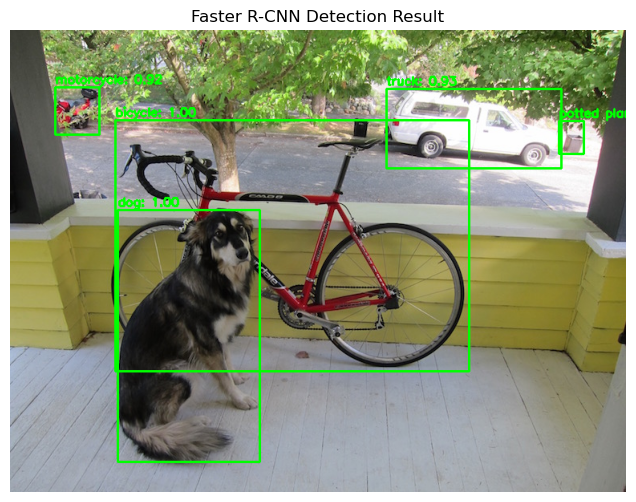


Detection results for Image2.jpg


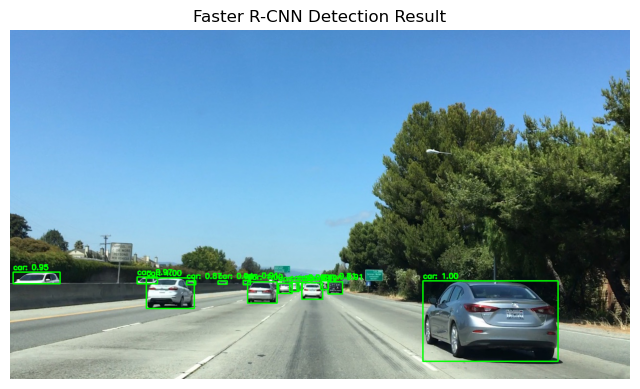

In [10]:
# Fixed Faster R-CNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
import torchvision.transforms as T

weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights)
model.eval()
model.to('cpu')  # ← crucial!

transform = weights.transforms()

# COCO class labels
COCO_CLASSES = weights.meta["categories"]

def frcnn_detect(img, score_thresh=0.5):
    """
    Perform object detection using Faster R-CNN.
    Draw bounding boxes, class labels, and confidence scores.
    """
    # Complete the function to do the functionality of FRCNN for object detection
    #TO DO
    # Transform image
    img_tensor = transform(img).unsqueeze(0)

    # Inference
    with torch.no_grad():
        outputs = model(img_tensor)[0]

    boxes = outputs["boxes"].numpy()
    scores = outputs["scores"].numpy()
    labels = outputs["labels"].numpy()

    # Convert image to NumPy for drawing
    img_np = np.array(img)

    for box, score, label in zip(boxes, scores, labels):
        if score < score_thresh:
            continue

        x1, y1, x2, y2 = map(int, box)
        class_name = COCO_CLASSES[label]

        # Draw bounding box
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Draw label + confidence
        text = f"{class_name}: {score:.2f}"
        cv2.putText(
            img_np,
            text,
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            2
        )

    # Show result
    plt.figure(figsize=(8, 6))
    plt.imshow(img_np)
    plt.axis("off")
    plt.title("Faster R-CNN Detection Result")
    plt.show()
# Feed Image1 and Image2 to the model and evaluate it
# TO DO
# Evaluate Image1 and Image2
image_paths = ["Image1.jpg", "Image2.jpg"]

for path in image_paths:
    print(f"\nDetection results for {path}")
    img = Image.open(path).convert("RGB")
    frcnn_detect(img)

<div dir="rtl" style="font-family: Vazirmatn, Tahoma; line-height: 1.9; text-align: justify;">

<h3 style="border-right: 5px solid #4CAF50; padding-right: 10px;">
تحلیل خروجی مرحله دوم – تشخیص اشیا (Object Detection)
</h3>

<p>
در این بخش، از مدل <b>Faster R-CNN</b> از پیش‌آموزش‌دیده بر روی دیتاست <b>COCO</b> برای تشخیص اشیای موجود در تصاویر ورودی استفاده شده است.
خروجی مدل شامل <span style="color:#1565C0;">کادرهای تشخیص (Bounding Box)</span>،
<span style="color:#1565C0;">برچسب کلاس</span> و
<span style="color:#1565C0;">امتیاز اطمینان</span> برای هر شیء می‌باشد.
</p>

<hr>

<p>
نتایج نشان می‌دهند که مدل در تشخیص اشیای اصلی صحنه عملکرد بسیار مناسبی دارد.
در تصویر اول، اشیای شاخصی مانند <b>سگ</b>، <b>دوچرخه</b> و <b>خودرو</b> با امتیاز اطمینان بسیار بالا
(<span style="color:#2E7D32;">نزدیک یا برابر با ۱</span>)
شناسایی شده‌اند.
</p>

<p>
کادرهای ترسیم‌شده به‌خوبی نواحی اصلی اشیا را پوشش می‌دهند و نشان‌دهنده توان مدل
در تشخیص اشیای <i>foreground</i> حتی در حضور پس‌زمینه‌های شلوغ هستند.
همچنین تشخیص اشیای کوچک‌تر مانند <b>موتورسیکلت</b> و <b>گلدان</b>
بیانگر حساسیت مناسب مدل به مقیاس‌های مختلف اشیاست،
هرچند دقت مکانی این کادرها نسبت به اشیای بزرگ‌تر کمتر است و به همین دلیل به نظر اشتباه تشخیص داده شده و باید  یکی از کادر های کوچک سطل آشغال باشد و نه گلدان.
</p>

<hr>

<p>
در تصویر دوم که یک صحنه جاده‌ای با تعداد زیادی خودرو را نمایش می‌دهد،
مدل موفق شده است خودروهای نزدیک و دور را به‌صورت هم‌زمان تشخیص دهد.
خودروهای نزدیک دارای کادرهای دقیق‌تر و امتیاز اطمینان بالاتری هستند،
در حالی که برای خودروهای دورتر، کادرها کوچک‌تر و فشرده‌تر شده‌اند.
</p>

<p>
این رفتار، ویژگی طبیعی مدل‌های مبتنی بر ناحیه محسوب می‌شود و نشان می‌دهد
که با افزایش فاصله و کاهش جزئیات بصری،
<span style="color:#C62828;">عدم قطعیت مدل افزایش می‌یابد</span>.
با این وجود، تشخیص صحیح کلاس <b>«car»</b> در اکثر موارد حفظ شده است.
</p>

<hr>

<p>
به‌طور کلی، نتایج این مرحله نشان می‌دهد که
<b>Faster R-CNN</b> در تشخیص اشیا، حتی در صحنه‌های پیچیده و چندشیئی،
عملکردی <span style="color:#2E7D32;"><b>پایدار و قابل اعتماد</b></span> دارد.
</p>

<p>
با این حال، محدودیت اصلی این روش در
عدم ارائه اطلاعات دقیق از مرز اشیا در سطح پیکسل
(<i>pixel-level</i>)
و پوشش ناقص برخی کادرها،
به‌ویژه برای اشیای کشیده یا دوردست، مشهود است.
این محدودیت، انگیزه اصلی استفاده از روش‌های پیشرفته‌تر مانند
<b>Semantic Segmentation</b> در مرحله بعدی پروژه محسوب می‌شود
که امکان درک دقیق‌تر ساختار صحنه را فراهم می‌کنند.
</p>

</div>


## 4. Task 3 – Semantic Segmentation

In this task, you are to use the pretrained **DeepLabV3+ with ResNet50 backbone (torchvision)** model for a segemntation task.

<span style="color:red">
Load the model using the "COCO_WITH_VOC_LABELS_V1" weights.

Do the required preprocessing
</span>


Segmentation results for Image2.jpg


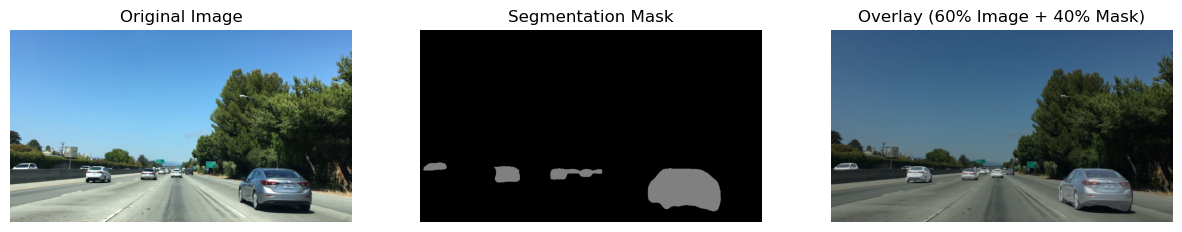


Segmentation results for Image3.jpg


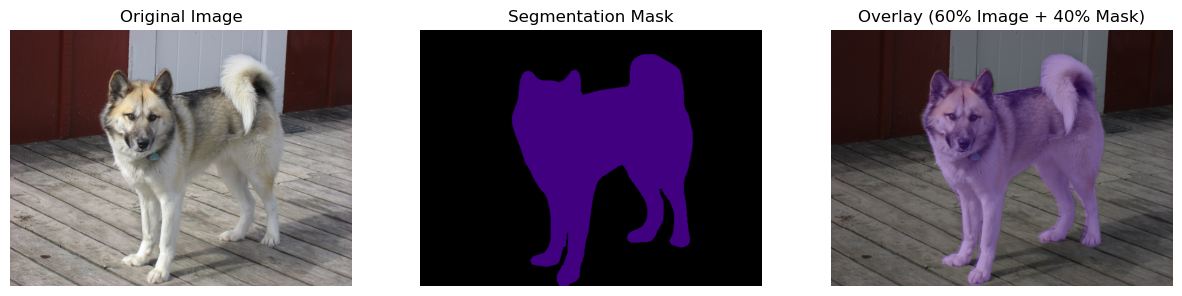


Segmentation results for Image6.jpg


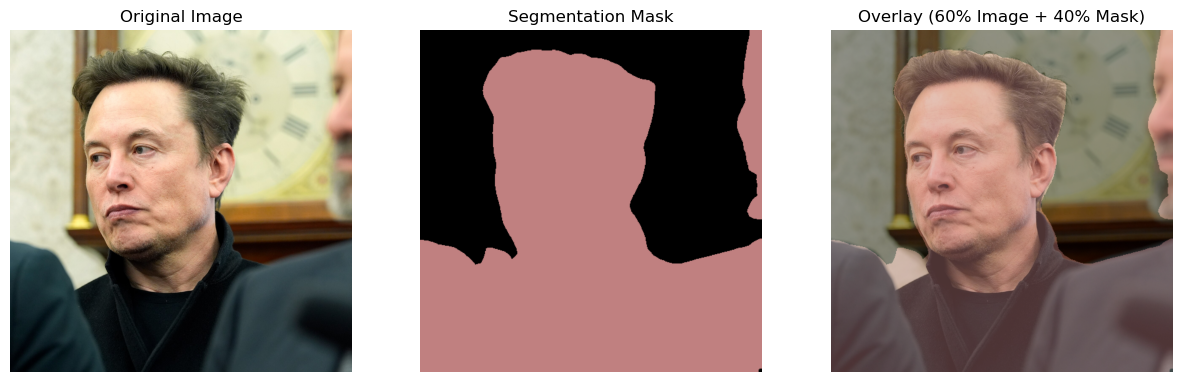

In [17]:
# TODO (Upload pretraind model)
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

seg_model = deeplabv3_resnet50(
    weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
)
seg_model.eval()
seg_model.to(device)

# TO DO (preprocessing)
seg_preprocess = transforms.Compose([
    transforms.Resize(520),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# PASCAL VOC colors (21 classes)
VOC_COLORS = np.array([
    [0, 0, 0],      # background
    [128, 0, 0],    # aeroplane
    [0, 128, 0],    # bicycle
    [128, 128, 0],  # bird
    [0, 0, 128],    # boat
    [128, 0, 128],  # bottle
    [0, 128, 128],  # bus
    [128, 128, 128],# car
    [64, 0, 0],     # cat
    [192, 0, 0],    # chair
    [64, 128, 0],   # cow
    [192, 128, 0],  # dining table
    [64, 0, 128],   # dog
    [192, 0, 128],  # horse
    [64, 128, 128], # motorbike
    [192, 128, 128],# person
    [0, 64, 0],     # potted plant
    [128, 64, 0],   # sheep
    [0, 192, 0],    # sofa
    [128, 192, 0],  # train
    [0, 192, 128]   # tv/monitor
])

def segment_image(img):
    input_tensor = seg_preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = seg_model(input_tensor)['out'][0]

    pred = output.argmax(0).cpu().numpy()

    # Create colored mask
    # TO DO
    h, w = pred.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls in range(len(VOC_COLORS)):
        color_mask[pred == cls] = VOC_COLORS[cls]

    color_mask = Image.fromarray(color_mask).resize(
        img.size, resample=Image.NEAREST
    )

    # Overlay (60% original + 40% mask)
    # TO DO
    overlay = Image.blend(
        img.convert("RGB"),
        color_mask.convert("RGB"),
        alpha=0.4
    )

    # Plot the orginal image and preprocessed version.
    # TO DO
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(color_mask)
    plt.title("Segmentation Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("Overlay (60% Image + 40% Mask)")
    plt.axis("off")

    plt.show()

    return pred


# Evaluate the model on Image2, Image3, and Image6
# TO DO
# Make sure you have your segmentation function defined or imported
# from your_module import segment_image

image_paths = ["Image2.jpg", "Image3.jpg", "Image6.jpg"]

for path in image_paths:
    print(f"\nSegmentation results for {path}")
    img = Image.open(path).convert("RGB")
    segment_image(img)

<div dir="rtl" style="font-family: Vazirmatn, Tahoma; line-height: 1.9; text-align: justify;">

<h3 style="border-right: 5px solid #673AB7; padding-right: 10px;">
تحلیل نهایی عملکرد مدل DeepLabV3-ResNet50
</h3>

<p>
در این بخش، عملکرد مدل
<b>DeepLabV3</b> با <b>backbone = ResNet-50</b>
که به‌صورت پیش‌آموزش‌دیده روی دیتاست
<span style="color:#1565C0;"><b>PASCAL VOC</b></span>
ارائه شده است، بر روی <b>سه تصویر با ماهیت متفاوت</b>
مورد ارزیابی قرار گرفت.
</p>

<hr>

<p>
تصویر <b>Image2</b> یک صحنه‌ی جاده‌ای شامل
چند خودرو در فواصل مختلف، مسیر آسفالته و پوشش گیاهی
را نشان می‌دهد.
در این تصویر، مدل تنها کلاس
<span style="color:#2E7D32;"><b>«car»</b></span>
را تشخیص داده و سایر اجزای محیطی به‌عنوان
<b>background</b> برچسب‌گذاری شده‌اند
که این رفتار کاملاً با
<span style="color:#EF6C00;">محدودیت کلاس‌های دیتاست PASCAL VOC</span>
سازگار است.
</p>

<p>
خودروهای نزدیک با دقت نسبی مناسبی تشخیص داده شده‌اند،
در حالی که خودروهای دورتر به‌صورت
<b>نواحی کوچک و ناپیوسته</b>
ظاهر شده‌اند که نشان‌دهنده‌ی
<span style="color:#C62828;">حساسیت مدل به مقیاس اشیاء</span>
و
<span style="color:#C62828;">کاهش عملکرد در تشخیص اشیاء کوچک</span>
است.
</p>

<hr>

<p>
در تصویر <b>Image3</b> که شامل یک <b>سگ</b>
با پس‌زمینه‌ای ساده و کنتراست مناسب است،
مدل عملکرد بسیار بهتری از خود نشان داده است.
شیء اصلی تصویر به‌صورت
<b>پیوسته</b> و با
<span style="color:#2E7D32;"><b>دقت بالا</b></span>
به‌عنوان کلاس
<b>«dog»</b>
سگمنت شده و مرزهای ماسک در بیشتر نواحی
<b>منسجم و دقیق</b>
هستند.
</p>

<p>
این نتیجه بیانگر آن است که زمانی که
<b>شیء هدف واضح، بزرگ و مشابه نمونه‌های موجود در دیتاست آموزشی</b>
باشد، مدل قادر است ماسک‌های
<i>segmentation</i>
با کیفیت بالاتری تولید کند.
</p>

<hr>

<p>
در مقابل، تصویر <b>Image6</b> که یک نمای نزدیک
از یک <b>فرد</b> در محیط داخلی و با حضور
عناصر مزاحم در پس‌زمینه را نمایش می‌دهد،
نشان می‌دهد که مدل در تشخیص کلاس
<span style="color:#1565C0;"><b>«person»</b></span>
عملکرد قابل قبولی دارد،
اما مرزهای سگمنتیشن در نواحی پیچیده مانند
<b>مو</b>، <b>گردن</b> و <b>شانه‌ها</b>
دقت کمتری دارند.
</p>

<p>
در برخی بخش‌ها نیز
<span style="color:#C62828;">هم‌پوشانی با پس‌زمینه</span>
یا افراد دیگر مشاهده می‌شود که بیانگر
محدودیت مدل در مرزبندی دقیق در صحنه‌های پیچیده است.
</p>

<hr>

<h4 style="color:#37474F;">
جمع‌بندی و نتیجه‌گیری
</h4>

<p>
به‌طور کلی، نتایج حاصل از این آزمایش نشان می‌دهد که
مدل <b>DeepLabV3-ResNet50</b>
در چارچوب دیتاست <b>PASCAL VOC</b>
عملکردی
<span style="color:#2E7D32;"><b>مطابق انتظار</b></span>
دارد و قادر است
<b>اشیاء واضح و بزرگ</b>
را با دقت مناسبی سگمنت کند.
</p>

<p>
با این حال،
<span style="color:#C62828;">
محدودیت در تنوع کلاس‌ها،
ضعف در تشخیص اشیاء کوچک
و عدم دقت بالا در مرزبندی‌های پیچیده
</span>
از جمله چالش‌های اصلی این مدل محسوب می‌شوند.
</p>

<p>
بنابراین، اگرچه این مدل برای
<b>اهداف آموزشی</b> و
<b>تحلیل‌های اولیه‌ی سگمنتیشن معنایی</b>
گزینه‌ای مناسب است،
اما برای کاربردهای عملی پیشرفته مانند
<b>تحلیل صحنه‌های رانندگی</b>
یا
<b>جداسازی دقیق افراد</b>،
استفاده از
<span style="color:#1565C0;"><b>دیتاست‌های تخصصی‌تر</b></span>
و
<span style="color:#1565C0;"><b>مدل‌های پیشرفته‌تر</b></span>
توصیه می‌شود.
</p>

</div>
